In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
# make this notebook work better with Scanpy
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns

In [3]:
# make output directories
import os
if not os.path.exists("scRNA_out"):
    os.mkdir("scRNA_out")

if not os.path.exists("scRNA_out/infercnv/"):
    os.mkdir("scRNA_out/infercnv/")

In [4]:
sc.set_figure_params(transparent=True, dpi_save=400)
sc.settings.figdir = "scRNA_out/infercnv/"

In [5]:
from pyensembl import EnsemblRelease

# release 98 uses human reference genome GRCh38
data = EnsemblRelease(98)

---
# Read in data

In [6]:
a_comb = sc.read("../data/scRNA/VUMC_COMBINED.h5ad"); a_comb

AnnData object with n_obs × n_vars = 22638 × 16464
    obs: 'HTAN Specimen ID', 'Cell_Type', 'Tumor_Type', 'Compartment', 'Patient'
    var: 'n_cells', 'gene_id', 'chromosome', 'start', 'end'
    obsm: 'X_pca', 'X_umap'

---
# Perform CNV inference globally

In [7]:
# Use `pyensembl` to map ENSG IDs to genomic loci
a_comb.var["chromosome"] = "0"
a_comb.var["start"] = 0
a_comb.var["end"] = 0
err_counter = 0
for i in a_comb.var_names:
    try:
        gene = data.gene_by_id(a_comb.var.gene_id[i])
        a_comb.var.loc[i,"chromosome"] = "chr{}".format(gene.contig)
        a_comb.var.loc[i,"start"] = gene.start
        a_comb.var.loc[i,"end"] = gene.end
    except ValueError as e:
        #print(e)
        err_counter += 1
print("{} errors in ENSEMBL mapping".format(err_counter))

0 errors in ENSEMBL mapping


In [18]:
a = a_comb[a_comb.obs.Patient != "", :].copy() ; a

AnnData object with n_obs × n_vars = 6914 × 16464
    obs: 'HTAN Specimen ID', 'Cell_Type', 'Tumor_Type', 'Compartment', 'Patient'
    var: 'n_cells', 'gene_id', 'chromosome', 'start', 'end'
    obsm: 'X_pca', 'X_umap'

---

In [ ]:
%%time
# run InferCNV
# provide stromal regions as "normal cells"
cnv.tl.infercnv(
    a,
    reference_key="Compartment",
    reference_cat=["Stroma"],
    window_size=200,
)
# determine clusters based on detected CNVs
cnv.tl.pca(a)
cnv.pp.neighbors(a, n_neighbors=int(np.sqrt(a.n_obs)))
cnv.tl.leiden(a, resolution=1.5)
# score detected CNVs in every spot
cnv.tl.cnv_score(a)

In [ ]:
# save CNV to file
np.save("scRNA_out/infercnv/uns_cnv_VUMC.npy", a.uns["cnv"])
# write to csv for compilation
a.obs[["cnv_leiden","cnv_score"]].to_csv("scRNA_out/infercnv/VUMC_cnv_leiden.csv")
# write CNV values to npz for compilation
np.savez_compressed("scRNA_out/infercnv/VUMC_cnv.npz", a.obsm["X_cnv"])

---

In [19]:
# or, read in results from previous run
# read in CNV matrix and put in a.obsm slot
tmp = np.load("scRNA_out/infercnv/VUMC_cnv.npz", allow_pickle="TRUE")
a.obsm["X_cnv"] = tmp.f.arr_0.item()
# read in CNV genomic partitions
a.uns["cnv"] = np.load("scRNA_out/infercnv/uns_cnv_VUMC.npy", allow_pickle="TRUE").item()
# read in cnv_score and cnv_leiden
a.obs = a.obs.merge(pd.read_csv("scRNA_out/infercnv/VUMC_cnv_leiden.csv", index_col=0), left_index=True, right_index=True)

Plotting Cell_Type CNV heatmap
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: Abnormal_Epithelium, Normal_Epithelium, Stroma
var_group_labels: chr1, chr2, chr3, etc.


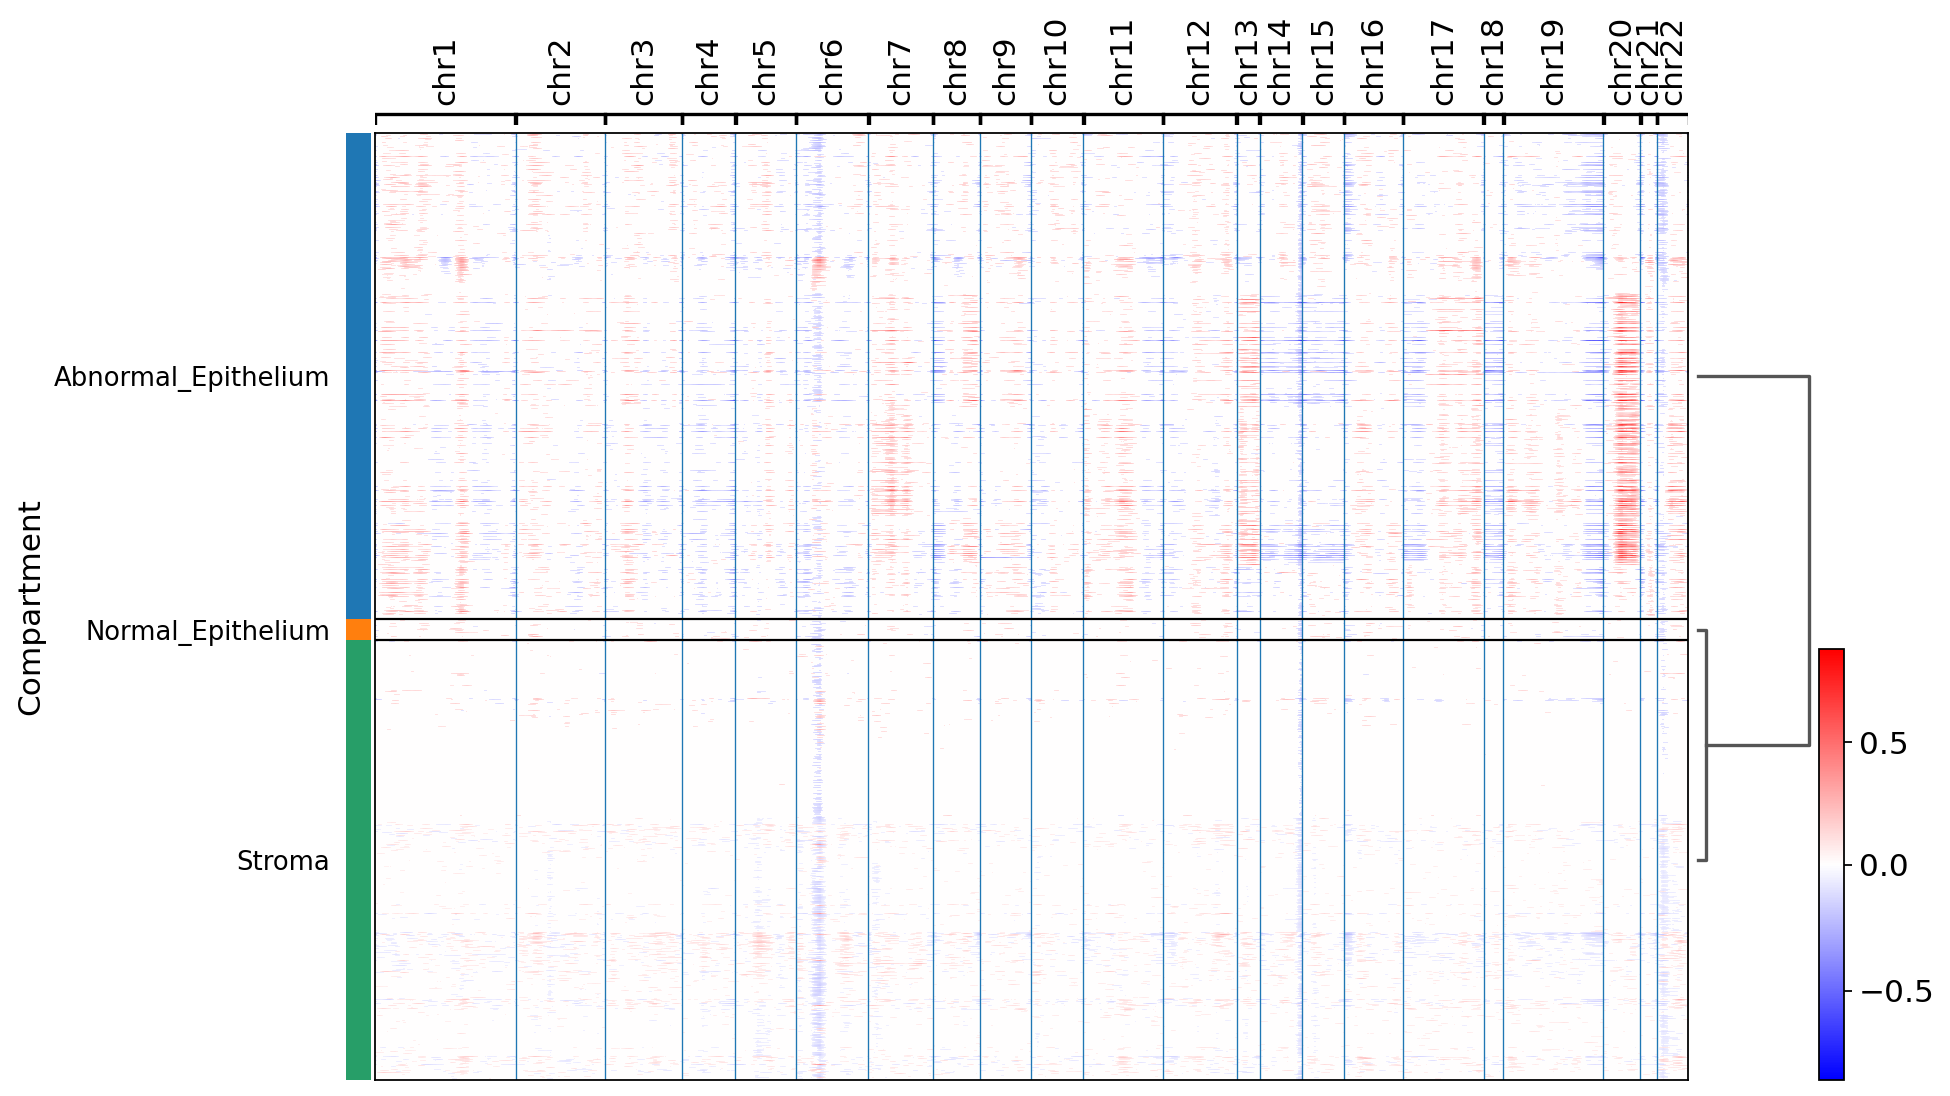

In [20]:
# plot heatmap with cell types
print("Plotting Cell_Type CNV heatmap")
cnv.pl.chromosome_heatmap(
    a,
    groupby="Compartment",
    save="_VUMC_compartment.png",
    dendrogram=True,
    figsize=(12,8),
)

Plotting Cell_Type CNV heatmap
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: ABS, ASC, B, etc.
var_group_labels: chr1, chr2, chr3, etc.


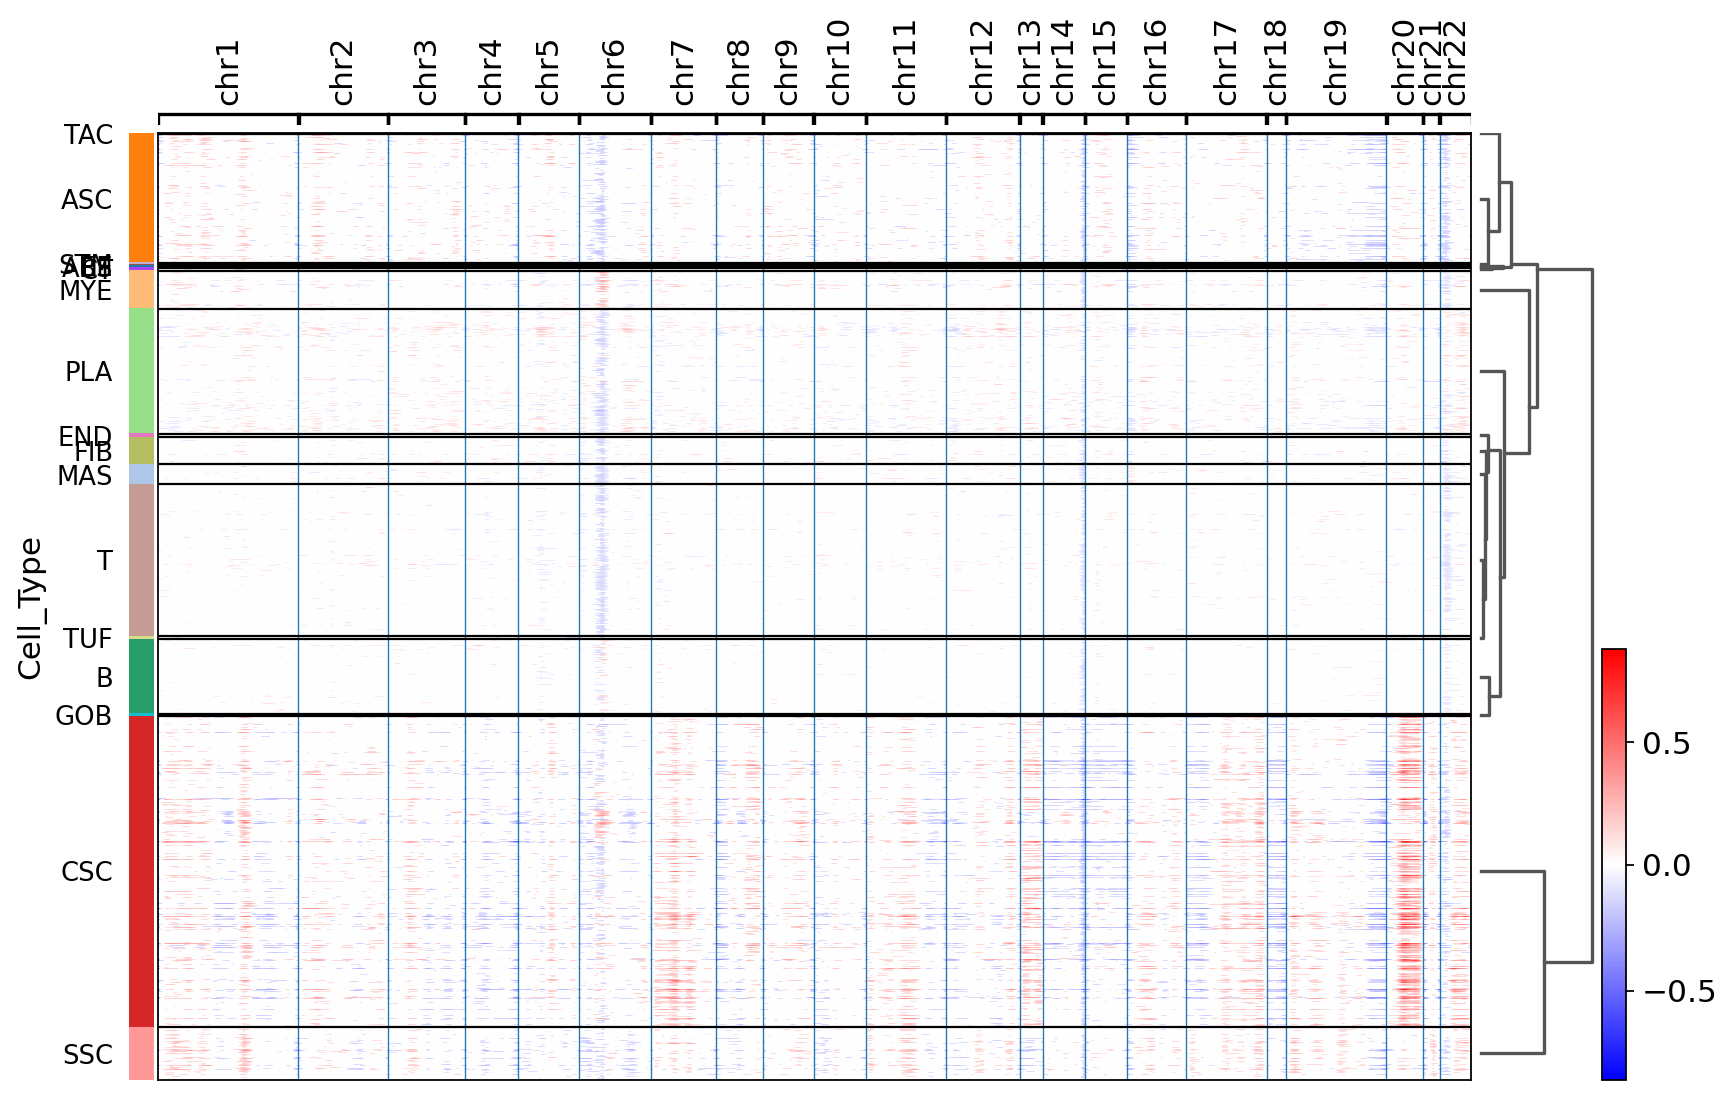

In [21]:
# plot heatmap with cell types
print("Plotting Cell_Type CNV heatmap")
cnv.pl.chromosome_heatmap(
    a,
    groupby="Cell_Type",
    save="_VUMC_CellType.png",
    dendrogram=True,
    figsize=(12,8),
)

Plotting CNV heatmap with tumor class
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: SSL/HP, MSI, MSS, etc.
var_group_labels: chr1, chr2, chr3, etc.


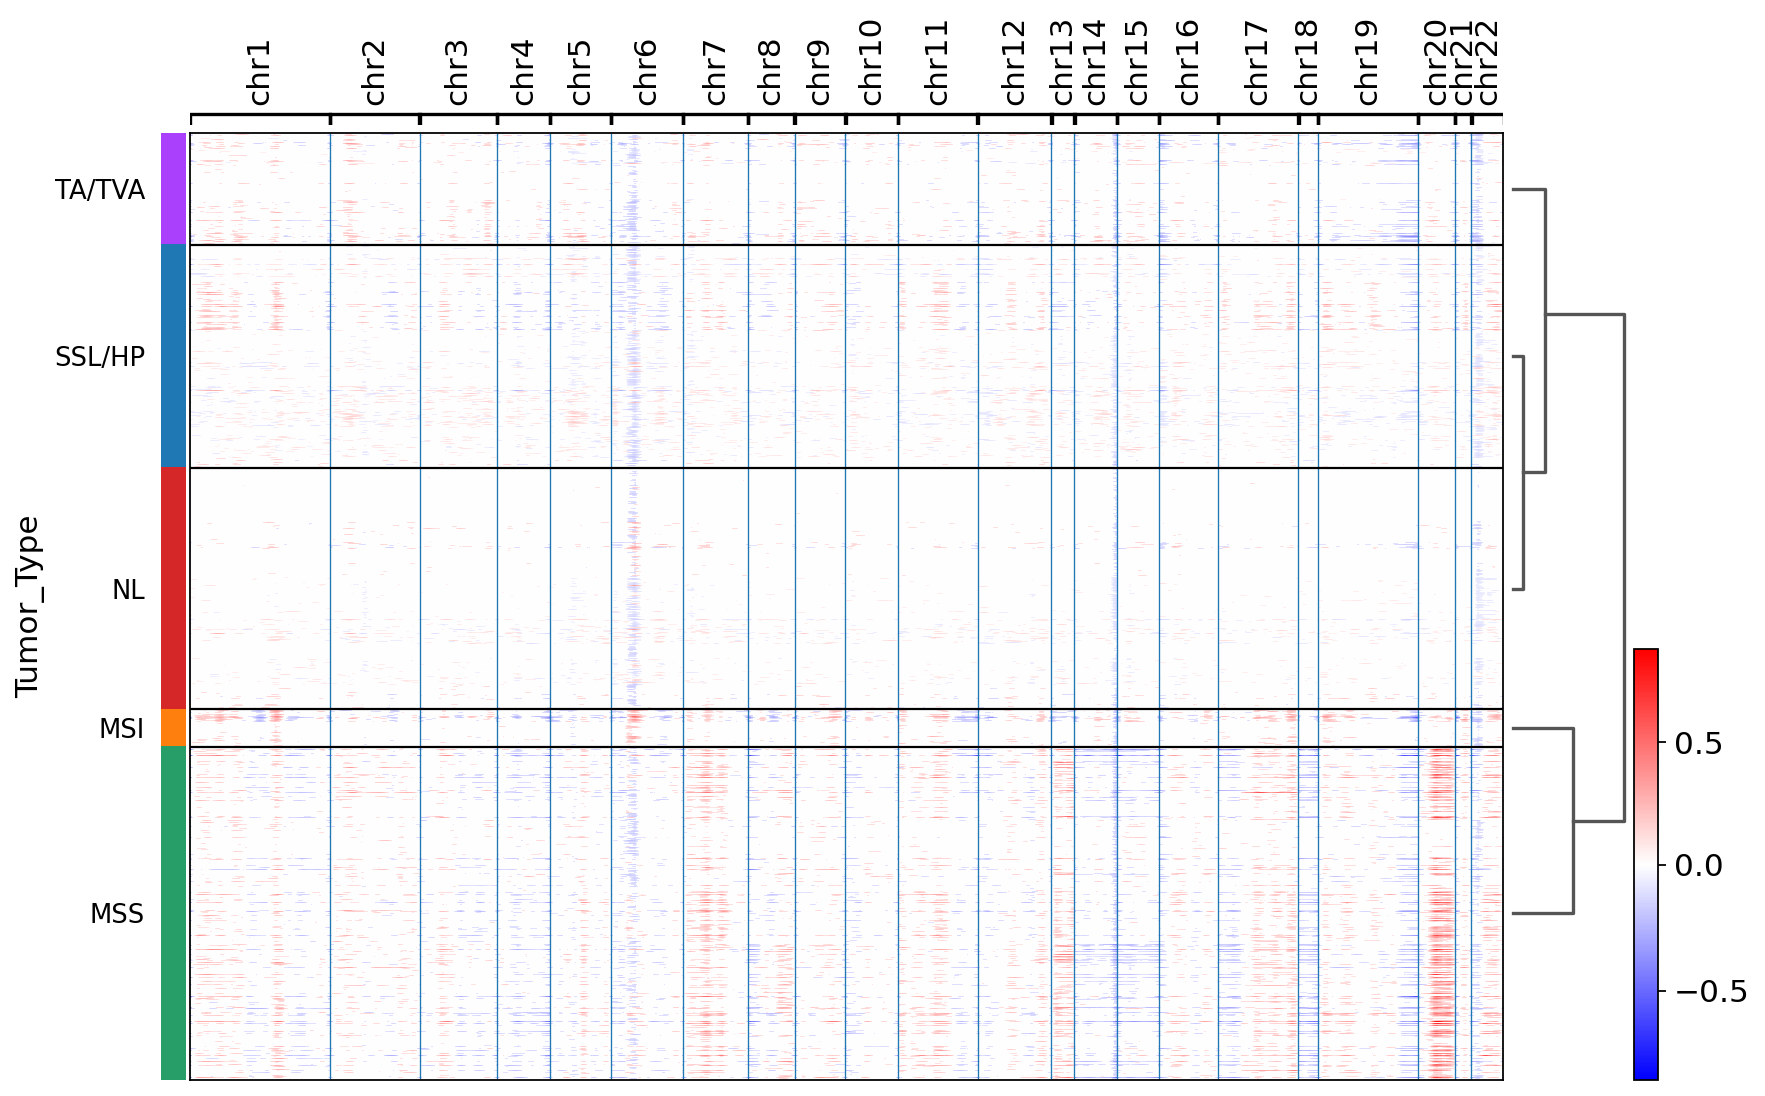

In [22]:
# plot heatmap with tumor type
print("Plotting CNV heatmap with tumor class")
cnv.pl.chromosome_heatmap(
    a,
    groupby="Tumor_Type",
    save="_VUMC_tumortype.png",
    dendrogram=True,
    figsize=(12,8),
)

Plotting CNV heatmap with patient
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: HTA11_01938, HTA11_06134, HTA11_07663, etc.
var_group_labels: chr1, chr2, chr3, etc.


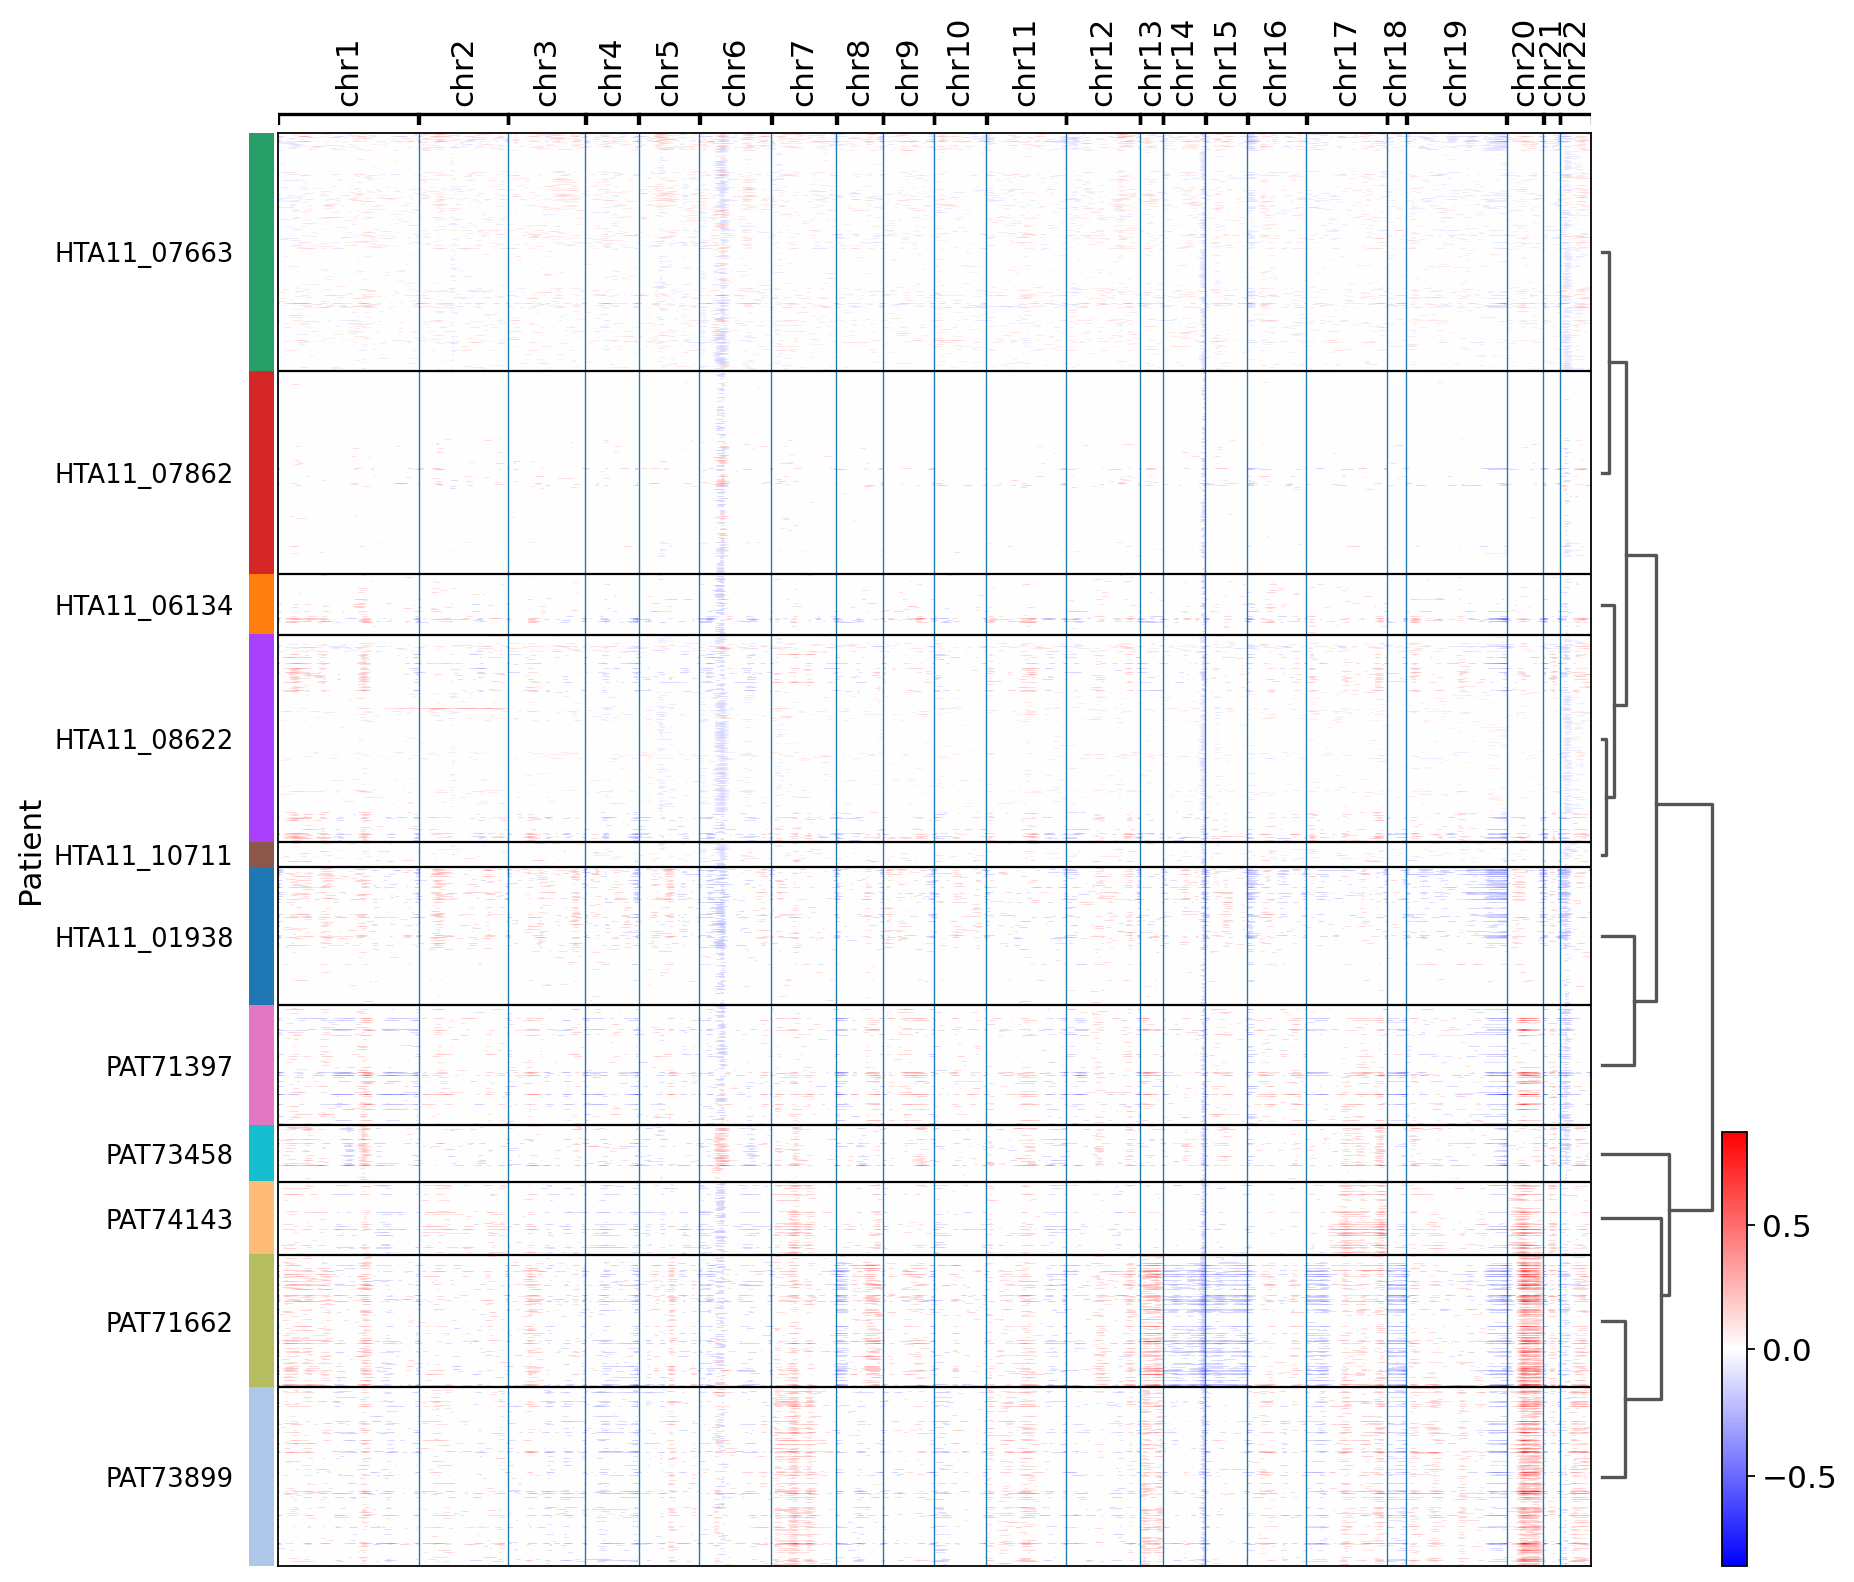

In [23]:
# plot heatmap with patient
print("Plotting CNV heatmap with patient")
cnv.pl.chromosome_heatmap(
    a,
    groupby="Patient",
    save="_VUMC_patient.png",
    dendrogram=True,
    figsize=(12,12),
)

In [24]:
# create cnv_leiden colordict
a.obs.cnv_leiden = a.obs.cnv_leiden.astype(str)
a.obs.cnv_leiden = a.obs.cnv_leiden.astype("category")
cnv_leiden_cdict = dict(zip(a.obs.cnv_leiden.cat.categories, sns.color_palette("tab20", len(a.obs.cnv_leiden.cat.categories)).as_hex()))
a.uns["cnv_leiden_colors"] = [cnv_leiden_cdict[x] for x in a.obs.cnv_leiden.cat.categories]

Plotting CNV heatmap with Leiden clusters
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 10, etc.
var_group_labels: chr1, chr2, chr3, etc.


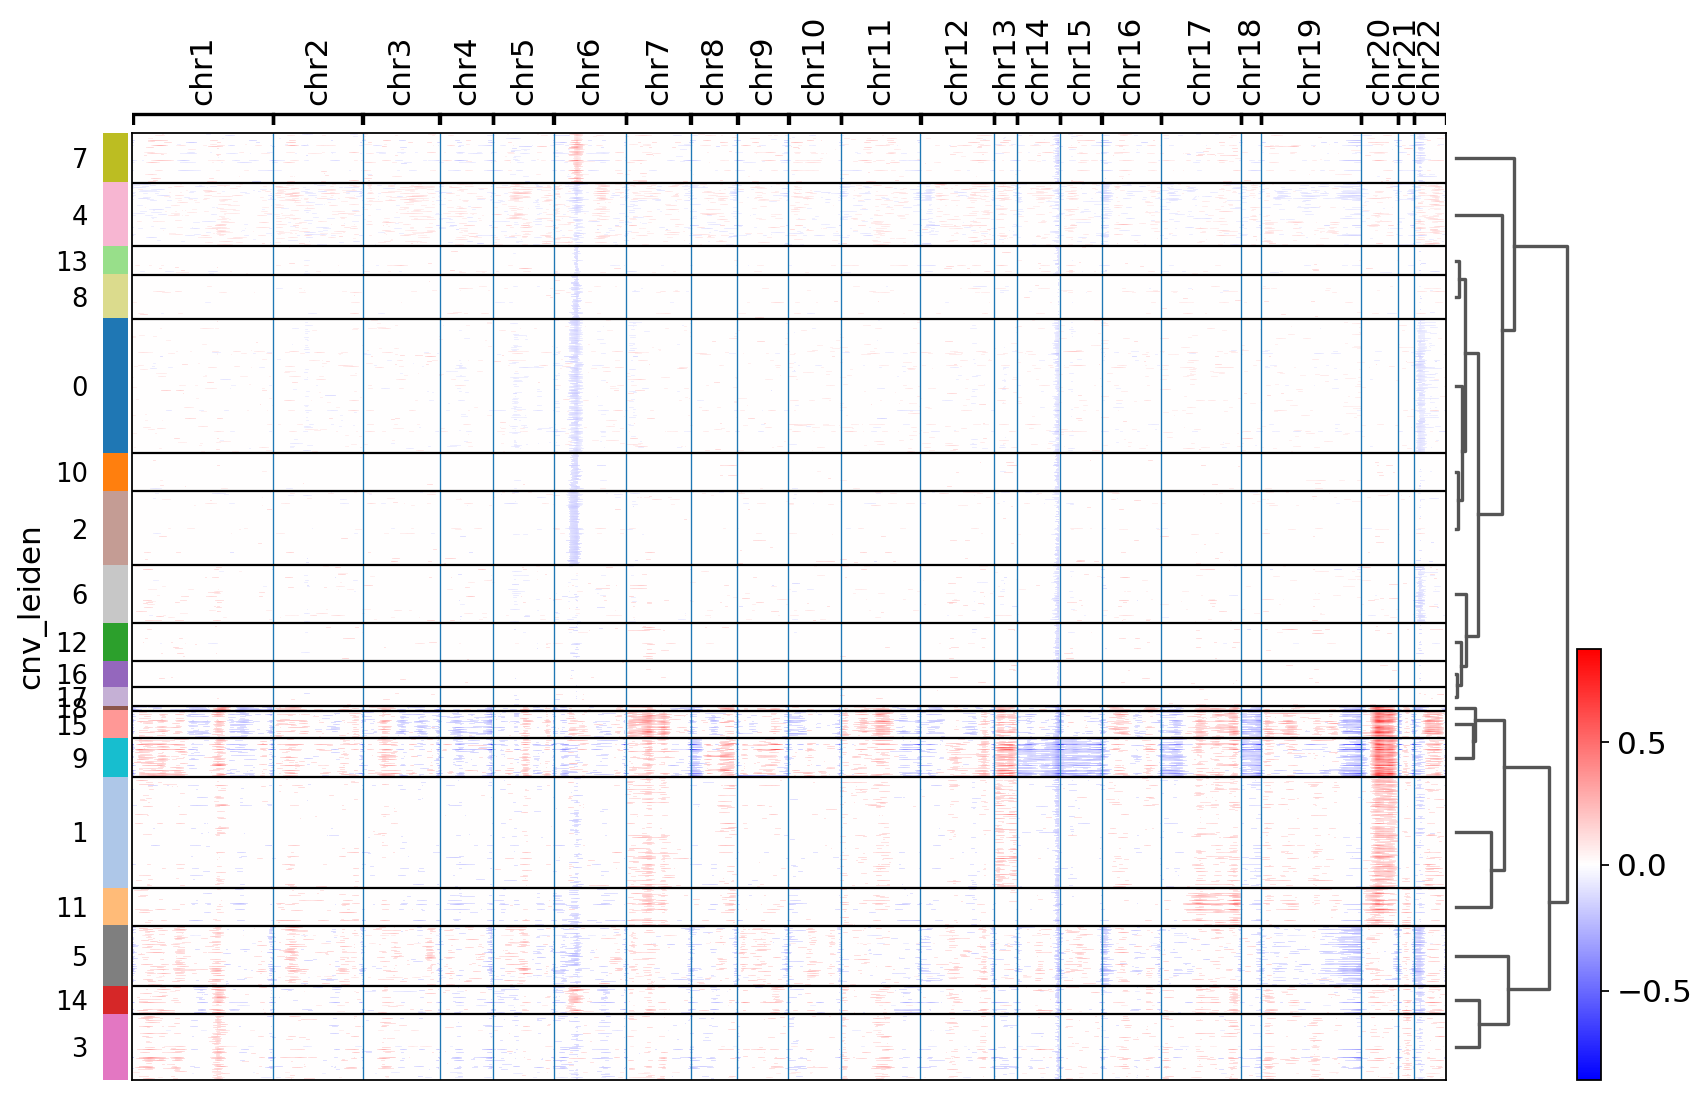

In [25]:
# plot heatmap with CNV Leiden clusters
print("Plotting CNV heatmap with Leiden clusters")
cnv.pl.chromosome_heatmap(
    a,
    groupby="cnv_leiden",
    save="_VUMC.png",
    dendrogram=True,
    figsize=(12,8),
)